In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV
from neural_regress.regress_lib import MultiOutputSeparateLassoCV
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features, transform_features2Xdict
from neural_regress.regress_eval_lib import compute_D2_per_unit
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

In [ ]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") 
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
data_h5 = load_from_hdf5(data_path)
subject_id = 'red_20241212-20241220'
PCA_subject_id = 'red_20241212-20241220' # 'paul_20241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
stim_names = data_dict['stimulus_names']
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
brain_area = [x.decode('utf-8') for x in data_dict['brain_area']]
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
print(f"Loading data from {data_path}")
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id, ) #+"_Lasso"

All stimulus files were found
Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_red_20241212-20241220.h5


In [80]:
data_h5

{'red_20241212-20241220': {'README': {'neuron_metadata': {'brain_area': 'Brain area each neuron belongs to.',
    'ncsnr': 'Noise ceiling / Signal-to-noise ratio for each neuron.',
    'peak_respwindow': 'Window of peak response over which responses are averaged for response_peak.',
    'reliability': 'Split-half reliability of each neuron.',
    'temporal_windows': 'Center of each timepoint in response_temporal.'},
   'repavg': {'response_peak': 'Response to each unique stimulus, averaged across repeats. Size: (n_stims, n_neurons)',
    'response_temporal': 'Temporal response to each unique stimulus, averaged across repeats. (n_timepoints, n_stims, n_neurons).',
    'stimulus_name': 'Name of each unique stimulus.'},
   'trials': {'response_peak': 'Response of each neuron during the peak response window of each trial. Size: (n_trials, n_neurons).',
    'response_temporal': 'Timeseries response of each neuron on each trial. Size: (n_timepoints, n_trials, n_neurons).',
    'session_num':

### Load and summarize the predictions

In [42]:
synfigdir = join(dataroot, "model_outputs", subject_id, "synopsis") #+"_Lasso"
os.makedirs(synfigdir, exist_ok=True)

In [26]:
import xarray as xr
model_name = "resnet50"
synopsis_xr = []
for model_name in ["resnet50", "resnet50_robust", "resnet50_clip", "resnet50_dino"]:
    pred_data = pkl.load(open(join(figdir, f"red_20241212-20241220_{model_name}_sweep_regressors_layers_pred_meta_RidgeLassoCV.pkl"), "rb"))
    pred_dict = pred_data['pred_dict']
    D2_per_unit_train_dict = pred_data['D2_per_unit_train_dict']
    D2_per_unit_test_dict = pred_data['D2_per_unit_test_dict']
    layer_dimreds = [k[0] for k in D2_per_unit_test_dict.keys()]
    regressors = [k[1] for k in D2_per_unit_test_dict.keys()]
    layers = [layer_dimred.split("_")[0] for layer_dimred in layer_dimreds]
    dimreds = [layer_dimred.split("_")[1] for layer_dimred in layer_dimreds]
    test_data = np.stack([D2_per_unit_test_dict[(lyr, regressor)]
                    for lyr, regressor in zip(layer_dimreds, regressors)], axis=0)
    train_data = np.stack([D2_per_unit_test_dict[(lyr, regressor)]
                    for lyr, regressor in zip(layer_dimreds, regressors)], axis=0)
    
    data_xr = xr.Dataset(
            data_vars={
                'train_score': (['methods', 'unit'], train_data),
                'test_score': (['methods', 'unit'], test_data),
            },
            coords={
                "modelname": ("methods", [model_name] * test_data.shape[0]),
                "layer": ("methods", layers),
                "regressor": ("methods", regressors),
                "dimred": ("methods", dimreds),
                "unit": np.arange(test_data.shape[1]),
                'subject_id': subject_id,
            }
        )
    synopsis_xr.append(data_xr)

synopsis_xr = xr.concat(synopsis_xr, dim="methods")
synopsis_xr['reliability'] = ('unit', reliability)
synopsis_xr['ncsnr'] = ('unit', ncsnr)
synopsis_xr['brain_area'] = ('unit', brain_area)

In [44]:
synopsis_xr.to_netcdf(join(synfigdir, f"{subject_id}_regression_layersweep_synopsis_xr.nc"))


In [27]:
synopsis_xr

<xarray.Dataset> Size: 49kB
Dimensions:      (methods: 36, unit: 64)
Coordinates:
    modelname    (methods) <U15 2kB 'resnet50' 'resnet50' ... 'resnet50_dino'
    layer        (methods) <U19 3kB '.layer4.Bottleneck0' ... '.layer4.Bottle...
    regressor    (methods) <U26 4kB 'MultiTaskLassoCV' ... 'RidgeCV'
    dimred       (methods) <U7 1kB 'pca1000' 'pca1000' ... 'pca1000' 'pca1000'
  * unit         (unit) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
    subject_id   <U21 84B 'red_20241212-20241220'
Dimensions without coordinates: methods
Data variables:
    train_score  (methods, unit) float64 18kB 0.485 0.6553 ... 0.2177 0.3749
    test_score   (methods, unit) float64 18kB 0.485 0.6553 ... 0.2177 0.3749
    reliability  (unit) float64 512B 0.9179 0.6987 0.9506 ... 0.08495 0.894
    ncsnr        (unit) float32 256B 0.8892 0.3586 1.201 ... 0.4315 0.1497 0.792
    brain_area   (unit) <U5 1kB 'l_aIT' 'l_aIT' 'l_aIT' ... 'l_aIT' 'l_aIT'

In [45]:
summary_df = synopsis_xr[["test_score", "reliability", "ncsnr", "brain_area"]].to_dataframe().reset_index()
summary_df.to_pickle(join(synfigdir, f"{subject_id}_regression_layersweep_synopsis_df.pkl"))

### Prediction as function of layer

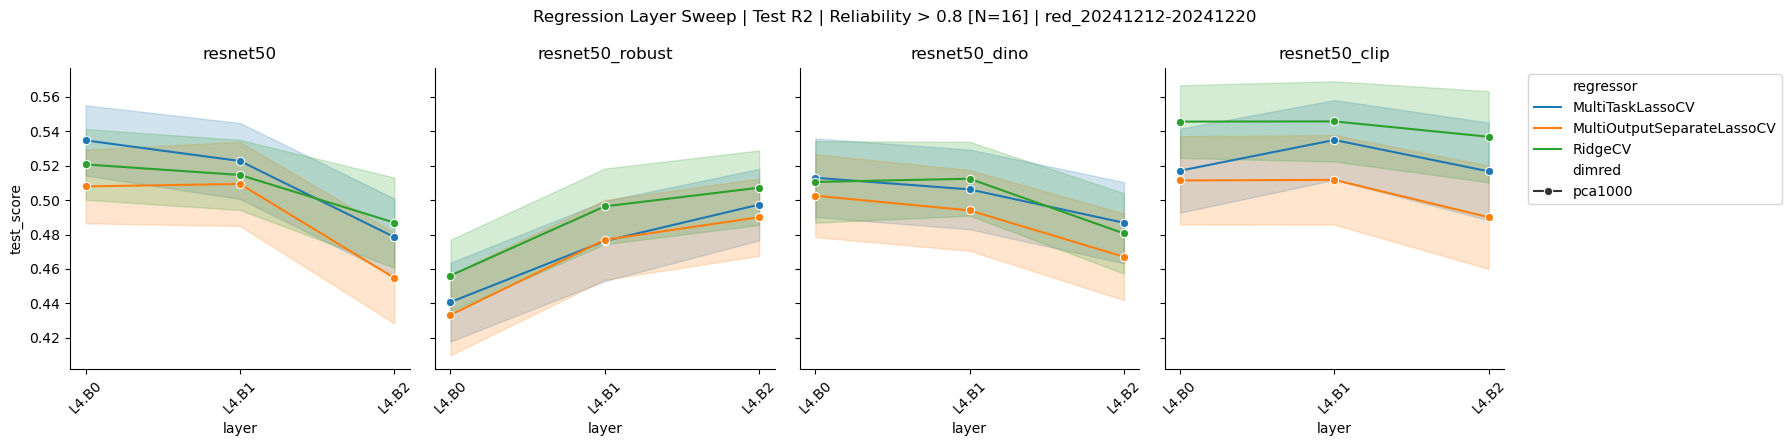

In [55]:
thresh = 0.8
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
summary_df_filter = summary_df.query(f"reliability > {thresh}")
unit_counts = (synopsis_xr["reliability"].data > thresh).sum()
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5), sharey=True)
axes = axes.flatten()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    subdf = summary_df_filter.query(f"modelname == @modelname")
    sns.lineplot(data=subdf, x="layer", y="test_score", 
                 style="dimred", hue="regressor", ax=axes[i],
                 errorbar="se",
                 legend=False if i < 3 else True, markers=True)
    axes[i].set_title(modelname)
    axes[i].tick_params(axis='x', rotation=45)
    # make the xticks be the layer names, simpler and more readable
    xticklabels = axes[i].get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    # axes[i].set_title("Training R2")

if axes[-1].get_legend():
    # Move legend outside the last subplot
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f"Regression Layer Sweep | Test R2 | Reliability > {thresh} [N={unit_counts}] | {synopsis_xr.subject_id.item()}")
plt.tight_layout()
# saveallforms(synfigdir, "")
plt.show()

In [51]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
thresh = 0.8
for thresh in [0, 0.2, 0.5, 0.8, 0.9]:
    summary_df_filter = summary_df.query(f"reliability > @thresh")
    unit_counts = (synopsis_xr["reliability"].data > thresh).sum()
    fig, axes = plt.subplots(1, 4, figsize=(18, 4.5), sharey=True)
    axes = axes.flatten()
    for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
        subdf = summary_df_filter.query(f"modelname == @modelname")
        sns.lineplot(data=subdf, x="layer", y="test_score", 
                    hue="dimred", style="regressor", ax=axes[i],
                    errorbar="se",
                    legend=False if i < 3 else True, markers=True)
        axes[i].set_title(modelname)
        axes[i].tick_params(axis='x', rotation=45)
        # make the xticks be the layer names, simpler and more readable
        xticklabels = axes[i].get_xticklabels()
        xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
        axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
        # axes[i].set_title("Training R2")

    if axes[-1].get_legend():
        # Move legend outside the last subplot
        axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Regression Layer Sweep | Test R2 | Reliability > {thresh} [N={unit_counts}] | {synopsis_xr.subject_id.item()}")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_layer_curve_per_model_reliability_thr{thresh}")
    plt.close()

In [59]:
summary_df.regressor.unique()

array(['MultiTaskLassoCV', 'MultiOutputSeparateLassoCV', 'RidgeCV'],
      dtype=object)

In [62]:
best_configs

,modelname,subject_id,unit,layer,regressor
0,resnet50,red_20241212-20241220,0,L4.B1,SharedLasso
1,resnet50,red_20241212-20241220,1,L4.B1,SepLasso
2,resnet50,red_20241212-20241220,2,L4.B0,SharedLasso
3,resnet50,red_20241212-20241220,4,L4.B1,SharedLasso
4,resnet50,red_20241212-20241220,6,L4.B0,SharedLasso
...,...,...,...,...,...
143,resnet50_robust,red_20241212-20241220,57,L4.B2,Ridge
144,resnet50_robust,red_20241212-20241220,59,L4.B2,SharedLasso
145,resnet50_robust,red_20241212-20241220,60,L4.B2,SharedLasso
146,resnet50_robust,red_20241212-20241220,61,L4.B2,Ridge


In [63]:
best_configs['regressor']

0      SharedLasso
1         SepLasso
2      SharedLasso
3      SharedLasso
4      SharedLasso
          ...     
143          Ridge
144    SharedLasso
145    SharedLasso
146          Ridge
147          Ridge
Name: regressor, Length: 148, dtype: object

In [67]:
all_methods = sorted(list(best_configs[["layer", "regressor"]].apply(tuple, axis=1).unique()))

### Model comparison best regressors

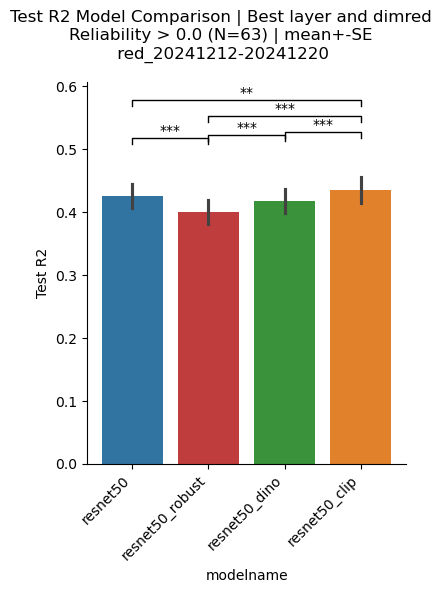

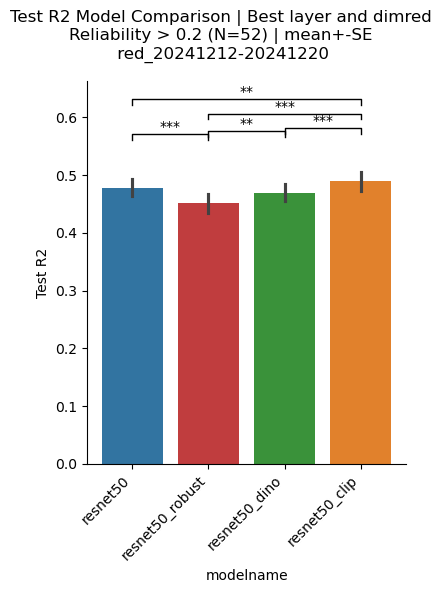

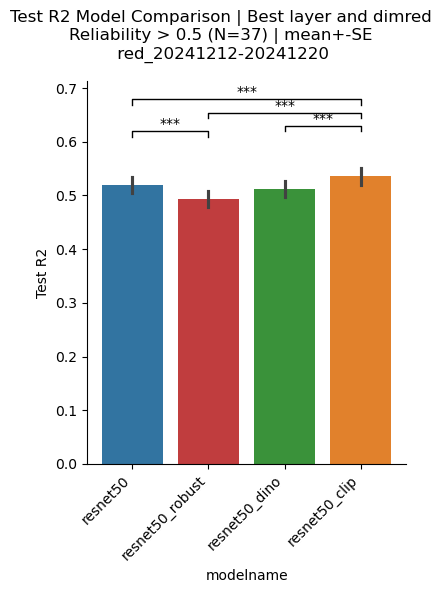

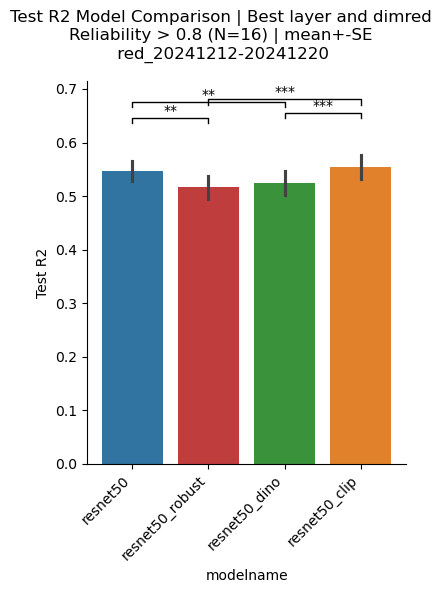

In [88]:
import scipy
# Group by subject_id, unit, modelname and get max test_score
models = ["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"]
for thresh in [0.0, 0.2, 0.5, 0.8]:
    best_scores = summary_df.query("reliability > @thresh").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
    pivot_scores = best_scores.pivot(index=['subject_id', 'unit'], columns='modelname', values='test_score')
    n_units = len(best_scores.groupby(['subject_id', 'unit']).size())
    
    # plot the best scores as a bar plot
    plt.figure(figsize=(4, 6))
    ax = sns.barplot(data=best_scores, x="modelname", y="test_score", 
                order=["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"],
                hue="modelname",
                errorbar="se"
                )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Test R2")
    plt.suptitle(f"Test R2 Model Comparison | Best layer and dimred\nReliability > {thresh} (N={n_units}) | mean+-SE\n {subject_id}")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}", figh=plt.gcf())
    # Perform paired t-tests between all pairs
    y_max = ax.get_ylim()[1]
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            scores1 = pivot_scores[models[i]]
            scores2 = pivot_scores[models[j]]
            t_stat, p_val = scipy.stats.ttest_rel(scores1, scores2)
            # Add significance annotation
            if p_val < 0.01:
                symbol = '***' if p_val < 0.001 else '**' if p_val < 0.01 else 'N.S.'
                y = y_max + 0.03 * (j-i) + 0.005 * i
                x1, x2 = i, j
                plt.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], 'k-', linewidth=1)
                plt.text((x1+x2)/2, y+0.01, symbol, ha='center', va='bottom')
    
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}_ttest_annot", figh=plt.gcf())
    plt.show()

In [90]:
summary_df.regressor.unique()

array(['MultiTaskLassoCV', 'MultiOutputSeparateLassoCV', 'RidgeCV'],
      dtype=object)

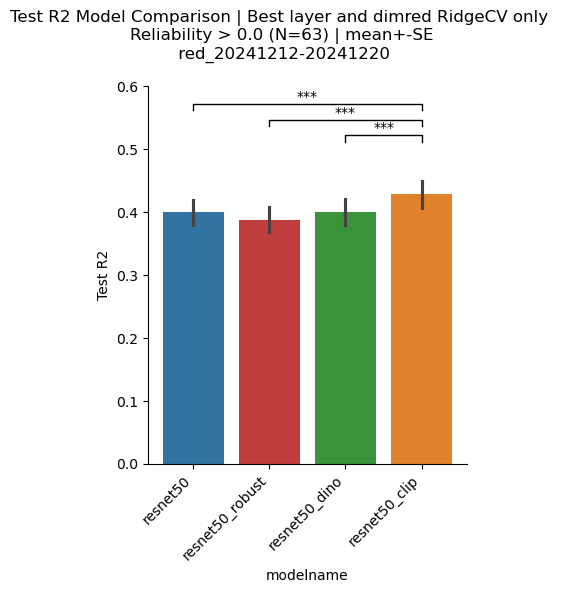

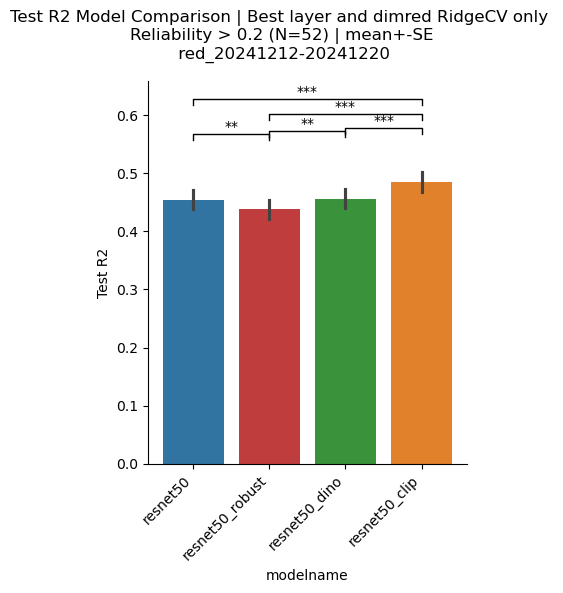

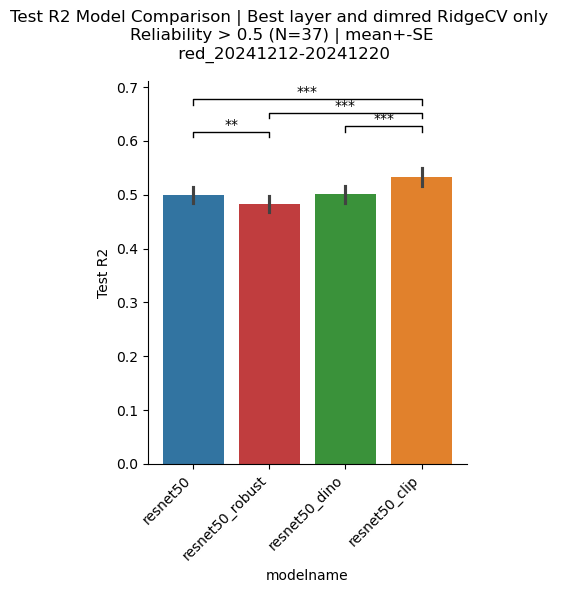

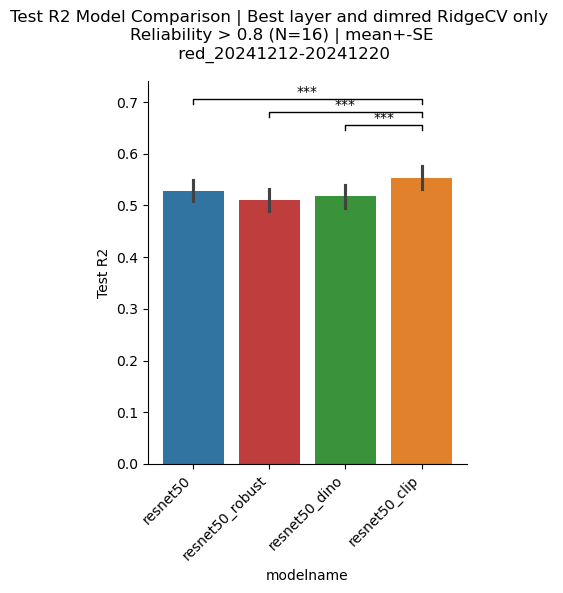

In [92]:
import scipy
# Group by subject_id, unit, modelname and get max test_score
models = ["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"]
for thresh in [0.0, 0.2, 0.5, 0.8]:
    best_scores = summary_df.query("reliability > @thresh and regressor == 'RidgeCV'").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
    pivot_scores = best_scores.pivot(index=['subject_id', 'unit'], columns='modelname', values='test_score')
    n_units = len(best_scores.groupby(['subject_id', 'unit']).size())
    
    # plot the best scores as a bar plot
    plt.figure(figsize=(4, 6))
    ax = sns.barplot(data=best_scores, x="modelname", y="test_score", 
                order=["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"],
                hue="modelname",
                errorbar="se"
                )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Test R2")
    plt.suptitle(f"Test R2 Model Comparison | Best layer and dimred RidgeCV only \nReliability > {thresh} (N={n_units}) | mean+-SE\n {subject_id}")
    plt.tight_layout()
    # saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}", figh=plt.gcf())
    # Perform paired t-tests between all pairs
    y_max = ax.get_ylim()[1]
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            scores1 = pivot_scores[models[i]]
            scores2 = pivot_scores[models[j]]
            t_stat, p_val = scipy.stats.ttest_rel(scores1, scores2)
            # Add significance annotation
            if p_val < 0.01:
                symbol = '***' if p_val < 0.001 else '**' if p_val < 0.01 else 'N.S.'
                y = y_max + 0.03 * (j-i) + 0.005 * i
                x1, x2 = i, j
                plt.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], 'k-', linewidth=1)
                plt.text((x1+x2)/2, y+0.01, symbol, ha='center', va='bottom')
    
    plt.tight_layout()
    # saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}_ttest_annot", figh=plt.gcf())
    plt.show()

### Best regression configurations

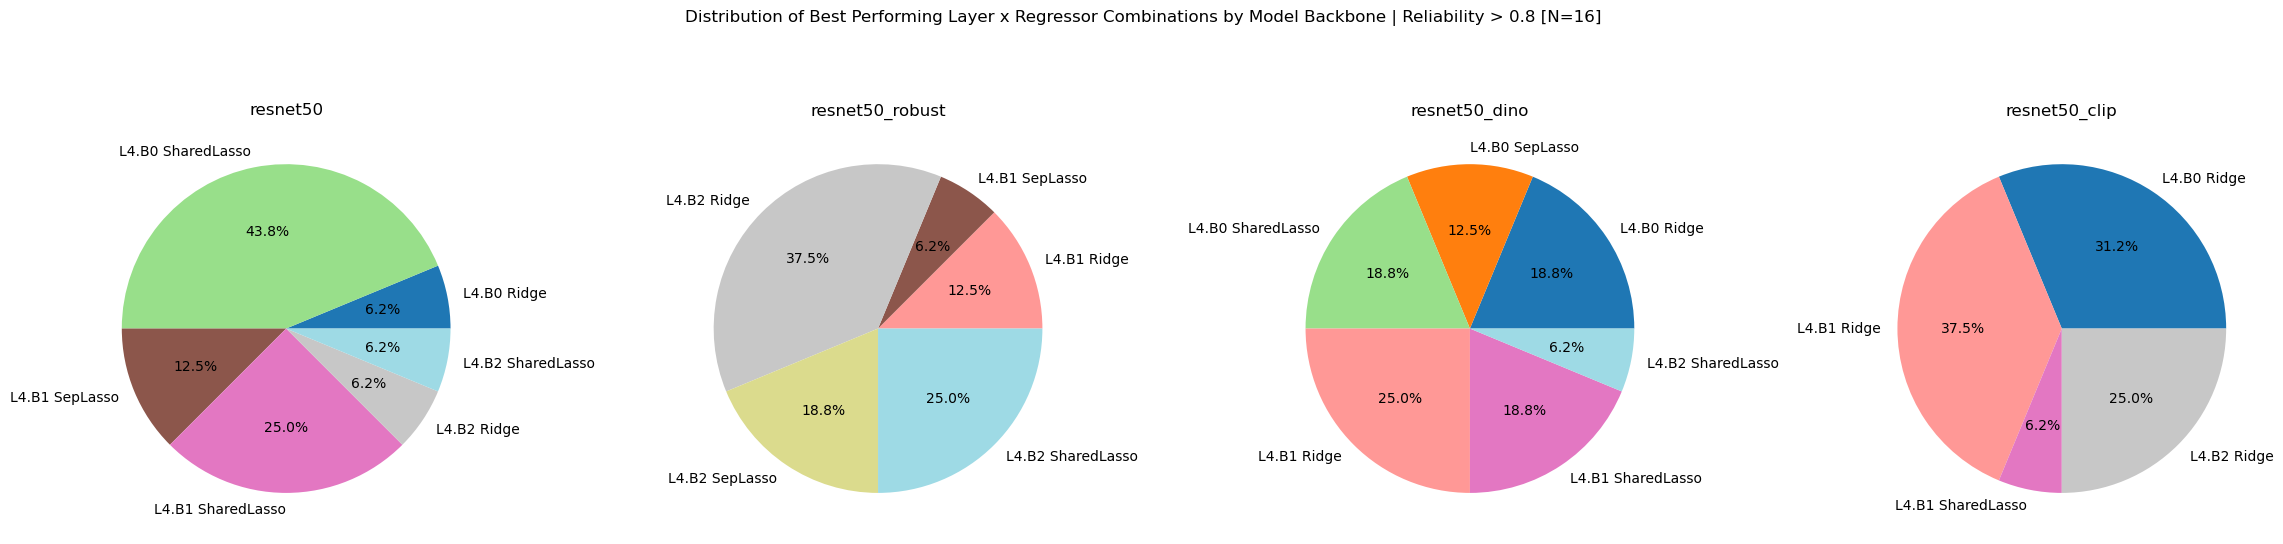

In [75]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
regressor_shorten_func = lambda x: x.replace("MultiTaskLassoCV", "SharedLasso").replace("RidgeCV", "Ridge").replace("MultiOutputSeparateLassoCV", "SepLasso")

thresh = 0.8
unit_counts = (synopsis_xr["reliability"].data > thresh).sum()
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'regressor']], include_groups=False
).reset_index()
# shorten the layer names and regressor names before plotting
best_configs['layer'] = best_configs['layer'].apply(shorten_func)
best_configs['regressor'] = best_configs['regressor'].apply(regressor_shorten_func)
# create a shared color palette for the layers and regressors
all_methods = sorted(list(best_configs[["layer", "regressor"]].apply(tuple, axis=1).unique()))
colors = plt.cm.tab20(np.linspace(0, 1, len(all_methods)))
color_dict = dict(zip(all_methods, colors))
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(23, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['layer', 'regressor']).size()
    # Create pie chart in subplot
    axes[i].pie(config_counts, 
                labels=[f"{layer} {regressor}" for layer, regressor in config_counts.index],
                autopct='%1.1f%%',
                colors=[color_dict[(layer, regressor)] for layer, regressor in config_counts.index])
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Layer x Regressor Combinations by Model Backbone | Reliability > {thresh} [N={unit_counts}]", y=1.05)
plt.tight_layout()
saveallforms(synfigdir, f"best_layer_regressor_distribution_by_model_reliability_thr{thresh}")
plt.show()

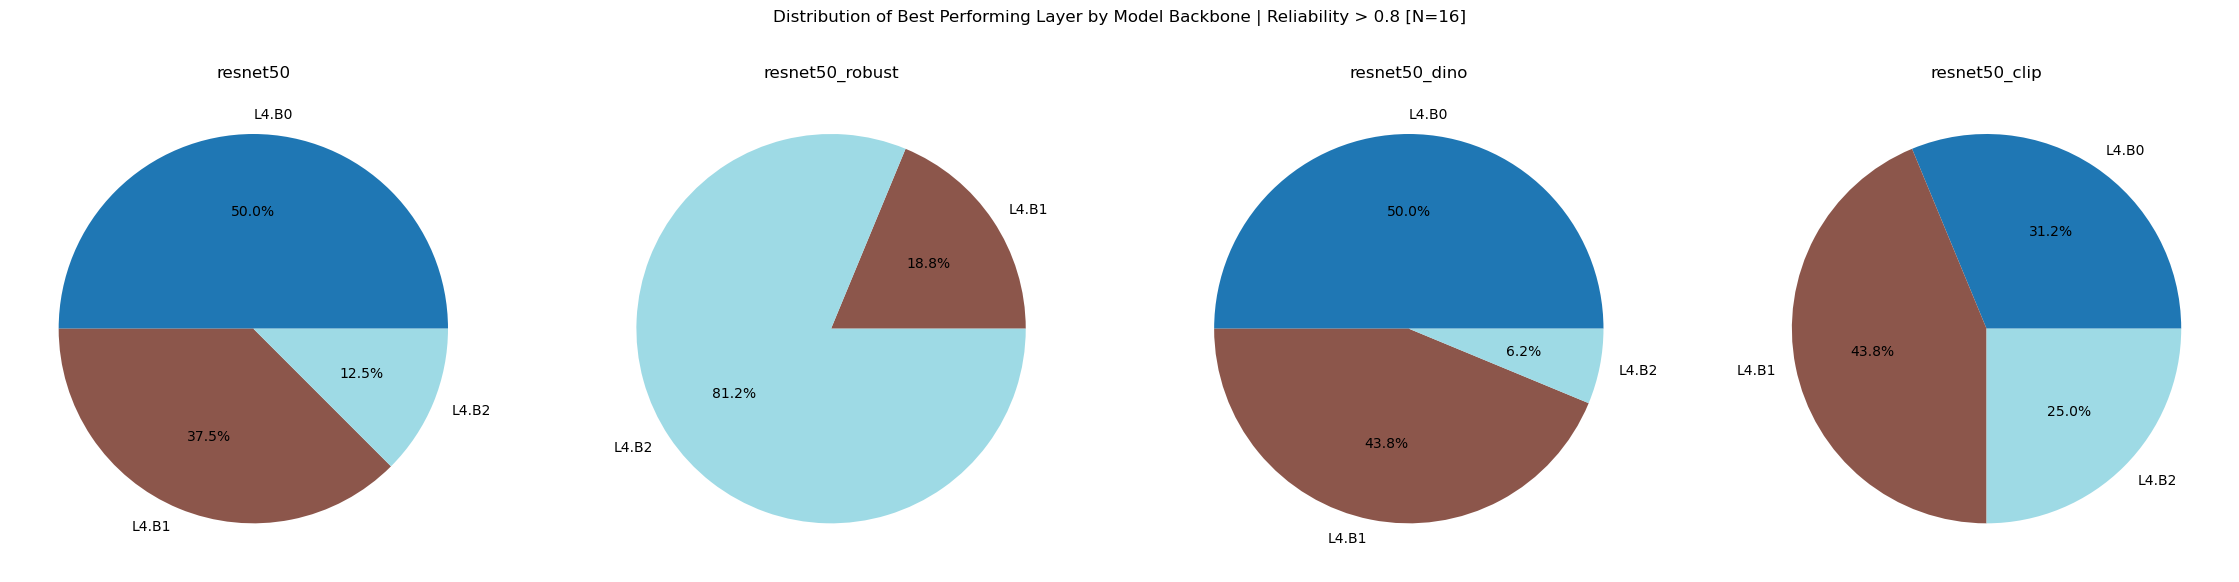

In [76]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
regressor_shorten_func = lambda x: x.replace("MultiTaskLassoCV", "SharedLasso").replace("RidgeCV", "Ridge").replace("MultiOutputSeparateLassoCV", "SepLasso")


thresh = 0.8
unit_counts = (synopsis_xr["reliability"].data > thresh).sum()
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'regressor']], include_groups=False
).reset_index()
# shorten the layer names and regressor names before plotting
best_configs['layer'] = best_configs['layer'].apply(shorten_func)
best_configs['regressor'] = best_configs['regressor'].apply(regressor_shorten_func)
# create a shared color palette for the layers and regressors
all_layers = sorted(list(best_configs["layer"].unique()))
colors = plt.cm.tab20(np.linspace(0, 1, len(all_layers)))
color_dict = dict(zip(all_layers, colors))
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(23, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['layer']).size()
    # Create pie chart in subplot
    axes[i].pie(config_counts, 
                labels=[f"{layer}" for layer in config_counts.index],
                autopct='%1.1f%%',
                colors=[color_dict[(layer)] for layer in config_counts.index])
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Layer by Model Backbone | Reliability > {thresh} [N={unit_counts}]", y=1.05)
plt.tight_layout()
saveallforms(synfigdir, f"best_layer_distribution_by_model_reliability_thr{thresh}")
plt.show()

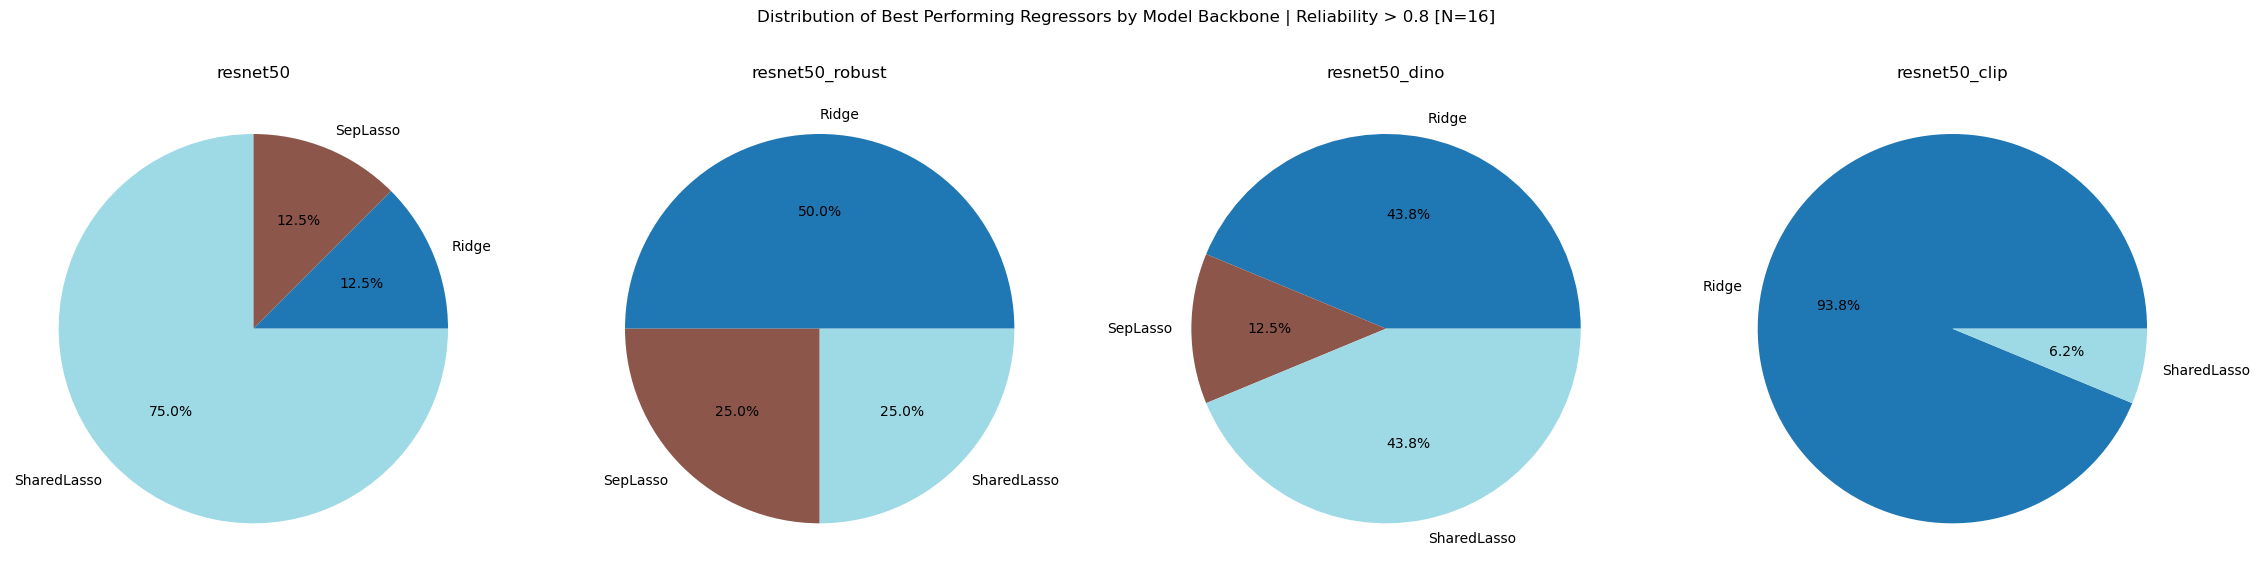

In [77]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
regressor_shorten_func = lambda x: x.replace("MultiTaskLassoCV", "SharedLasso").replace("RidgeCV", "Ridge").replace("MultiOutputSeparateLassoCV", "SepLasso")

thresh = 0.8
unit_counts = (synopsis_xr["reliability"].data > thresh).sum()
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'regressor']], include_groups=False
).reset_index()
# shorten the layer names and regressor names before plotting
best_configs['layer'] = best_configs['layer'].apply(shorten_func)
best_configs['regressor'] = best_configs['regressor'].apply(regressor_shorten_func)
# create a shared color palette for the layers and regressors
all_regressors = sorted(list(best_configs["regressor"].unique()))
colors = plt.cm.tab20(np.linspace(0, 1, len(all_regressors)))
color_dict = dict(zip(all_regressors, colors))
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(23, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['regressor']).size()
    # Create pie chart in subplot
    axes[i].pie(config_counts, 
                labels=[f"{regressor}" for regressor in config_counts.index],
                autopct='%1.1f%%',
                colors=[color_dict[(regressor)] for regressor in config_counts.index])
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Regressors by Model Backbone | Reliability > {thresh} [N={unit_counts}]", y=1.05)
plt.tight_layout()
saveallforms(synfigdir, f"best_regressor_distribution_by_model_reliability_thr{thresh}")
plt.show()

### Plot the Unit selection Procedure

In [112]:
final_experiment_synopsis_xr = synopsis_xr.sel(methods=(synopsis_xr.layer == '.layer4.Bottleneck1') & \
    (synopsis_xr.regressor != "MultiOutputSeparateLassoCV") & \
    synopsis_xr.modelname.isin(["resnet50", "resnet50_robust"]))
final_experiment_synopsis_xr = final_experiment_synopsis_xr.set_index(
    methods=["modelname", "layer", "regressor", "dimred"]
)

In [113]:
final_experiment_synopsis_xr

<xarray.Dataset> Size: 8kB
Dimensions:      (methods: 4, unit: 64)
Coordinates:
  * unit         (unit) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
    subject_id   <U21 84B 'red_20241212-20241220'
  * methods      (methods) object 32B MultiIndex
  * modelname    (methods) <U15 240B 'resnet50' 'resnet50' ... 'resnet50_robust'
  * layer        (methods) <U19 304B '.layer4.Bottleneck1' ... '.layer4.Bottl...
  * regressor    (methods) <U26 416B 'MultiTaskLassoCV' 'RidgeCV' ... 'RidgeCV'
  * dimred       (methods) <U7 112B 'pca1000' 'pca1000' 'pca1000' 'pca1000'
Data variables:
    train_score  (methods, unit) float64 2kB 0.4914 0.6682 ... 0.2328 0.5295
    test_score   (methods, unit) float64 2kB 0.4914 0.6682 ... 0.2328 0.5295
    reliability  (unit) float64 512B 0.9179 0.6987 0.9506 ... 0.08495 0.894
    ncsnr        (unit) float32 256B 0.8892 0.3586 1.201 ... 0.4315 0.1497 0.792
    brain_area   (unit) <U5 1kB 'l_aIT' 'l_aIT' 'l_aIT' ... 'l_aIT' 'l_aIT'

In [114]:

final_experiment_synopsis_xr.sel(modelname="resnet50_robust", regressor="MultiTaskLassoCV",).test_score[0]

<xarray.DataArray 'test_score' (unit: 64)> Size: 512B
array([ 0.40131856,  0.65982437,  0.42981276,  0.09955757,  0.42889106,
        0.38659683,  0.55955407,  0.48423335,  0.3342297 ,  0.52465258,
        0.4563734 ,  0.44794372,  0.28222196,  0.12984918,  0.17177974,
        0.48170421,  0.49189692,  0.11305239,  0.45944946,  0.49673063,
       -0.01658432,  0.44449557,  0.35943884,  0.4701429 ,  0.1177757 ,
        0.60499243,  0.07927369,  0.06363136,  0.46346668,  0.33532302,
        0.45492958,  0.44620969,  0.35291514,  0.51906133,  0.29962394,
        0.36012829,  0.4966015 ,  0.5183503 ,  0.29697566,  0.30128091,
        0.35617549,  0.45128223,  0.29533741,  0.45451607,  0.67407539,
        0.41659923,  0.16631436,  0.16824571,  0.24798572,  0.42051694,
        0.22102658,  0.54584253,  0.25710632,  0.07674445,  0.56584472,
        0.33660236,  0.40733588,  0.43447843,  0.074817  ,  0.40788197,
        0.21711136,  0.36492199,  0.25987096,  0.50601577])
Coordinates:
  * unit        (unit) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
    subject_id  <U21 84B 'red_20241212-20241220'
    methods     object 8B ('.layer4.Bottleneck1', 'pca1000')
    layer       <U19 76B '.layer4.Bottleneck1'
    dimred      <U7 28B 'pca1000'
    modelname   <U15 60B 'resnet50_robust'
    regressor   <U16 64B 'MultiTaskLassoCV'

In [140]:
# Average test scores across methods axis
k = 7
avg_test_scores = final_experiment_synopsis_xr.test_score.mean(dim='methods')
# Find unit with top k average R2 scores
best_unit_ids = avg_test_scores.argsort(axis=0)[-k:][::-1].values  # Reverse order to get high to low
print(f"Units with highest average R2: {best_unit_ids}")
print(f"Average R2 scores: {avg_test_scores[best_unit_ids].values}")  # Reverse scores to match unit order

Units with highest average R2: [44  1 25 54 51  9 37]
Average R2 scores: [0.68328848 0.65764968 0.62485592 0.56196572 0.55635125 0.55471296
 0.55315311]


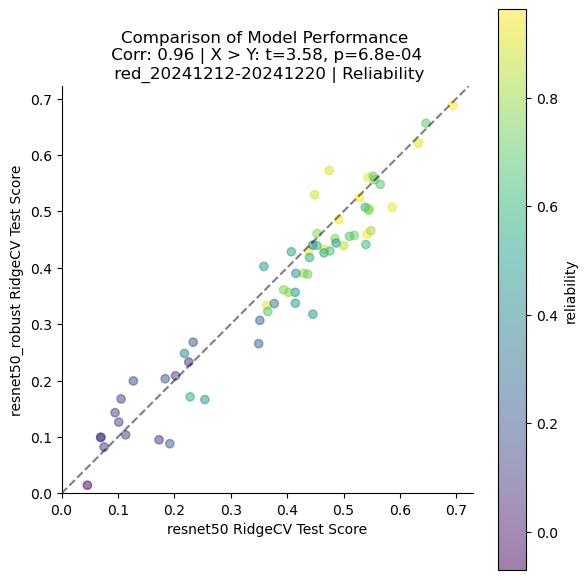

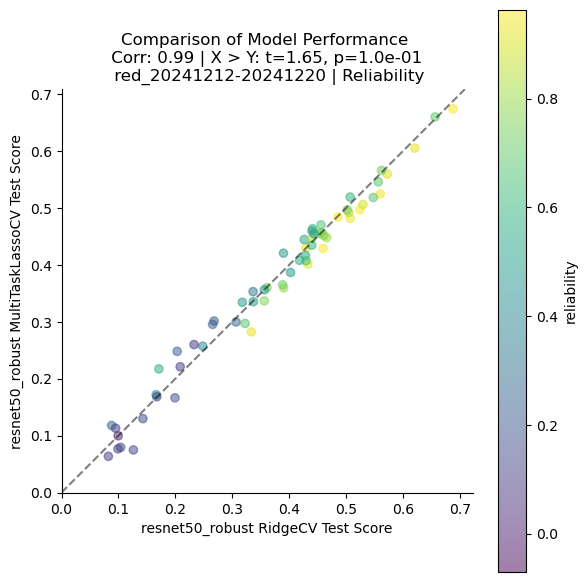

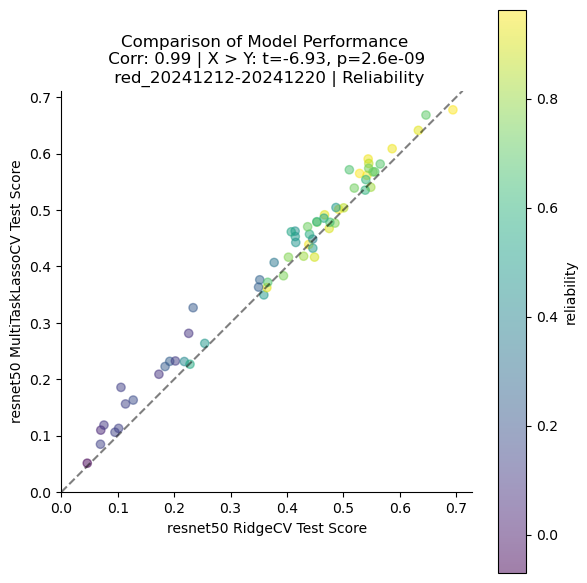

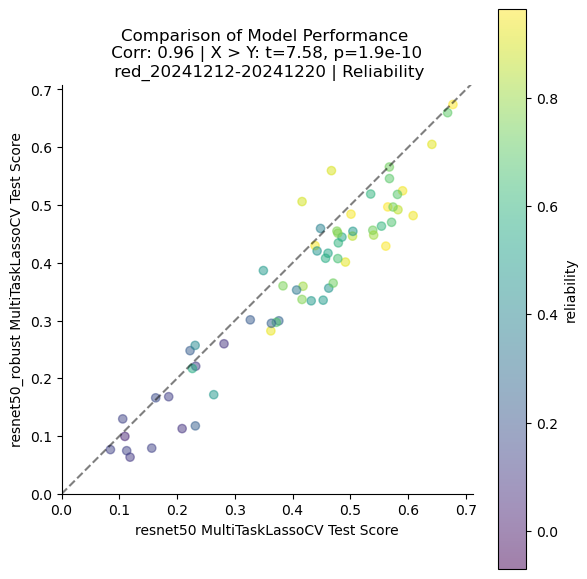

In [137]:
def plot_model_comparison(synopsis_xr, model1, model2, regressor1, regressor2, color_by="ncsnr",
                          titlestr=""):
    """Plot comparison of test scores between two models/regressors
    
    Args:
        synopsis_xr: xarray Dataset containing model results
        model1: Name of first model to compare
        model2: Name of second model to compare  
        regressor1: Name of first regressor to compare
        regressor2: Name of second regressor to compare
    """
    # Plot two rows of data against each other
    fig, ax = plt.subplots(figsize=(6, 6))
    xvalues = synopsis_xr.sel(modelname=model1, regressor=regressor1).test_score[0]
    yvalues = synopsis_xr.sel(modelname=model2, regressor=regressor2).test_score[0]
    # compute the correlation coefficient
    corr_coeff = np.corrcoef(xvalues, yvalues)[0, 1]
    # compute the paired t-test
    t_stat, p_val = scipy.stats.ttest_rel(xvalues, yvalues)
    # Create scatter plot with colorbar
    scatter = ax.scatter(xvalues, yvalues,
                        c=synopsis_xr[color_by],
                        alpha=0.5)
    plt.colorbar(scatter, label=color_by)
    
    ax.axline([0, 0], slope=1, linestyle='--', color='k', alpha=0.5) # Add diagonal line
    # Add labels
    ax.set_xlabel(f'{model1} {regressor1} Test Score')
    ax.set_ylabel(f'{model2} {regressor2} Test Score') 
    ax.set_title(f'Comparison of Model Performance \n Corr: {corr_coeff:.2f} | X > Y: t={t_stat:.2f}, p={p_val:.1e} \n {titlestr}')
    # Make axes equal and set limits
    ax.set_aspect('equal')
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    
    plt.tight_layout()
    return fig


figh = plot_model_comparison(final_experiment_synopsis_xr, "resnet50", "resnet50_robust", "RidgeCV", "RidgeCV", 
                            color_by="reliability", titlestr=f"{subject_id} | Reliability")
saveallforms(synfigdir, f"model_comparison_resnet50xRidgeCV_resnet50_robustxRidgeCV_reliability")
figh = plot_model_comparison(final_experiment_synopsis_xr, "resnet50_robust", "resnet50_robust", "RidgeCV", "MultiTaskLassoCV", 
                            color_by="reliability", titlestr=f"{subject_id} | Reliability")
saveallforms(synfigdir, f"model_comparison_resnet50_robustxRidgeCV_resnet50_robustxMultiTaskLassoCV_reliability")
figh = plot_model_comparison(final_experiment_synopsis_xr, "resnet50", "resnet50", "RidgeCV", "MultiTaskLassoCV", 
                            color_by="reliability", titlestr=f"{subject_id} | Reliability")
saveallforms(synfigdir, f"model_comparison_resnet50xRidgeCV_resnet50xMultiTaskLassoCV_reliability")
figh = plot_model_comparison(final_experiment_synopsis_xr, "resnet50", "resnet50_robust", "MultiTaskLassoCV", "MultiTaskLassoCV", 
                            color_by="reliability", titlestr=f"{subject_id} | Reliability")
saveallforms(synfigdir, f"model_comparison_resnet50xMultiTaskLassoCV_resnet50_robustxMultiTaskLassoCV_reliability")

### Scratch

In [ ]:
import numpy as np
import xarray as xr

# Suppose your dictionary is called D2_per_unit_test_dict
# and has keys like ('.layer4.Bottleneck0_pca1000', 'MultiTaskLassoCV'), etc.

# 1. Extract the unique layers and models
layer_dimreds = [k[0] for k in D2_per_unit_test_dict.keys()]
regressors = [k[1] for k in D2_per_unit_test_dict.keys()]
layers = [layer_dimred.split("_")[0] for layer_dimred in layer_dimreds]
dimreds = [layer_dimred.split("_")[1] for layer_dimred in layer_dimreds]
data = np.stack([D2_per_unit_test_dict[(lyr, regressor)]
                 for lyr, regressor in zip(layer_dimreds, regressors)], axis=0)
# 4. Make an xarray.DataArray, assigning coordinate names
da_testR2 = xr.DataArray(
    data,
    dims=["methods", "unit"],
    coords={
        "modelname": ("methods", [model_name] * data.shape[0]),
        "layer": ("methods", layers),
        "regressor": ("methods", regressors),
        "dimred": ("methods", dimreds),
        "unit": np.arange(data.shape[1]),
    },
)

In [9]:
D2_per_unit_test_dict[('.layer4.Bottleneck0_pca1000', 'MultiTaskLassoCV')]

array([0.43464972, 0.66720964, 0.40071251, 0.11729859, 0.50800714,
       0.34774102, 0.46164884, 0.46644787, 0.43617222, 0.54867118,
       0.51914367, 0.53613055, 0.38672832, 0.15200017, 0.26562228,
       0.59031423, 0.57485473, 0.18387724, 0.44564848, 0.51474056,
       0.02515469, 0.52003068, 0.50574027, 0.55750469, 0.21208425,
       0.64768094, 0.1349851 , 0.08431222, 0.53811973, 0.41770763,
       0.46409956, 0.49677139, 0.40051967, 0.54533246, 0.34010864,
       0.43474203, 0.61193286, 0.6184722 , 0.38113532, 0.33945414,
       0.43693017, 0.52350958, 0.31454004, 0.45120556, 0.72495628,
       0.42562321, 0.19161553, 0.19407229, 0.26339885, 0.4296772 ,
       0.23716627, 0.57350736, 0.25632747, 0.07416061, 0.57670781,
       0.36682751, 0.4855691 , 0.4880836 , 0.07696566, 0.45656203,
       0.23837758, 0.46230519, 0.24846775, 0.4102152 ])

In [18]:
da

<xarray.DataArray (methods: 9, unit: 64)> Size: 5kB
array([[0.43464972, 0.66720964, 0.40071251, 0.11729859, 0.50800714,
        0.34774102, 0.46164884, 0.46644787, 0.43617222, 0.54867118,
        0.51914367, 0.53613055, 0.38672832, 0.15200017, 0.26562228,
        0.59031423, 0.57485473, 0.18387724, 0.44564848, 0.51474056,
        0.02515469, 0.52003068, 0.50574027, 0.55750469, 0.21208425,
        0.64768094, 0.1349851 , 0.08431222, 0.53811973, 0.41770763,
        0.46409956, 0.49677139, 0.40051967, 0.54533246, 0.34010864,
        0.43474203, 0.61193286, 0.6184722 , 0.38113532, 0.33945414,
        0.43693017, 0.52350958, 0.31454004, 0.45120556, 0.72495628,
        0.42562321, 0.19161553, 0.19407229, 0.26339885, 0.4296772 ,
        0.23716627, 0.57350736, 0.25632747, 0.07416061, 0.57670781,
        0.36682751, 0.4855691 , 0.4880836 , 0.07696566, 0.45656203,
        0.23837758, 0.46230519, 0.24846775, 0.4102152 ],
       [0.41885667, 0.66241219, 0.38409208, 0.07485104, 0.50912981,
        0.31584816, 0.46552908, 0.44861321, 0.42839733, 0.54445479,
        0.50295678, 0.49895983, 0.37774314, 0.12938897, 0.262094  ,
        0.57722559, 0.58021158, 0.1590424 , 0.42237835, 0.52379837,
        0.02108547, 0.49061721, 0.49263531, 0.53939103, 0.17660724,
        0.63029824, 0.11176557, 0.08165069, 0.52110872, 0.38988483,
        0.44623198, 0.4673518 , 0.3803499 , 0.51662729, 0.35011874,
...
        0.45322498, 0.49290187, 0.32617596, 0.5169533 , 0.32793209,
        0.36415794, 0.58178749, 0.55464636, 0.34633057, 0.20987514,
        0.38583247, 0.40289137, 0.26267165, 0.37709165, 0.71953733,
        0.36503159, 0.14364785, 0.1689066 , 0.16577914, 0.39452574,
        0.20140681, 0.49750872, 0.217278  , 0.08022061, 0.5453004 ,
        0.30134653, 0.3628679 , 0.46863347, 0.09163789, 0.39742558,
        0.11410873, 0.40073477, 0.18883079, 0.33192411],
       [0.42162012, 0.66829777, 0.36591061, 0.07516544, 0.48019479,
        0.2931958 , 0.41480839, 0.43602004, 0.38282559, 0.52639264,
        0.4853784 , 0.52558433, 0.35358201, 0.09565578, 0.20542839,
        0.53047102, 0.51991082, 0.13480666, 0.40263548, 0.50255861,
        0.02964426, 0.4523483 , 0.42438329, 0.5045499 , 0.15129716,
        0.60845226, 0.12168896, 0.09521732, 0.46846603, 0.36604096,
        0.44656254, 0.4969383 , 0.33352176, 0.52418368, 0.33829379,
        0.37278355, 0.60202844, 0.59070546, 0.3451777 , 0.25031825,
        0.38827251, 0.4759236 , 0.24421317, 0.39519175, 0.70886506,
        0.3643498 , 0.1462094 , 0.15646456, 0.20658844, 0.39033649,
        0.18623783, 0.54237271, 0.19389269, 0.08473248, 0.54432026,
        0.35120559, 0.42382384, 0.46798294, 0.06841818, 0.44773333,
        0.18815156, 0.40183047, 0.21772804, 0.37485793]])
Coordinates:
    layer      (methods) <U19 684B '.layer4.Bottleneck0' ... '.layer4.Bottlen...
    regressor  (methods) <U26 936B 'MultiTaskLassoCV' ... 'RidgeCV'
    dimred     (methods) <U7 252B 'pca1000' 'pca1000' ... 'pca1000' 'pca1000'
  * unit       (unit) int64 512B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Dimensions without coordinates: methods